In [1]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db
from firebase_admin import storage


cred = credentials.Certificate("admin-sdk.json")
firebase_admin.initialize_app(cred,{
    'databaseURL': 'https://iot-solar-database-default-rtdb.firebaseio.com/',
    'storageBucket':'iot-solar-database.appspot.com'
})

bucket = storage.bucket()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.0


In [4]:
raw_dataset = pd.read_csv('dataset-solar\Plant_1_generation+sensor.csv')

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

DATE   TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
3152  17/06/2020  22:45            22.150570           21.480377          0.0   
3153  17/06/2020  23:00            22.129816           21.389024          0.0   
3154  17/06/2020  23:15            22.008275           20.709211          0.0   
3155  17/06/2020  23:30            21.969495           20.734963          0.0   
3156  17/06/2020  23:45            21.909288           20.427972          0.0   

      DC_POWER  AC_POWER  
3152       0.0       0.0  
3153       0.0       0.0  
3154       0.0       0.0  
3155       0.0       0.0  
3156       0.0       0.0

In [6]:
dataset['HOUR'],dataset['MINUTE']=dataset['TIME'].str.split(':',1).str
del dataset['TIME']
dataset['DAY'],dataset['MONTH_YEAR']=dataset['DATE'].str.split('/',1).str
del dataset['DATE']
dataset['MONTH'],dataset['YEAR']=dataset['MONTH_YEAR'].str.split('/',1).str
del dataset['MONTH_YEAR']
dataset.head()

AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  DC_POWER  AC_POWER  \
0            25.184316           22.857507          0.0       0.0       0.0   
1            25.084589           22.761668          0.0       0.0       0.0   
2            24.935753           22.592306          0.0       0.0       0.0   
3            24.846130           22.360852          0.0       0.0       0.0   
4            24.621525           22.165423          0.0       0.0       0.0   

  HOUR MINUTE DAY MONTH  YEAR  
0    0     00  15    05  2020  
1    0     15  15    05  2020  
2    0     30  15    05  2020  
3    0     45  15    05  2020  
4    1     00  15    05  2020

In [7]:
del dataset['YEAR']
dataset = dataset[ ['MINUTE'] + [ col for col in dataset.columns if col != 'MINUTE' ] ]
dataset = dataset[ ['HOUR'] + [ col for col in dataset.columns if col != 'HOUR' ] ]
dataset = dataset[ ['MONTH'] + [ col for col in dataset.columns if col != 'MONTH' ] ]
dataset = dataset[ ['DAY'] + [ col for col in dataset.columns if col != 'DAY' ] ]
del dataset['DAY']
del dataset['MONTH']
dataset

HOUR MINUTE  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0       0     00            25.184316           22.857507          0.0   
1       0     15            25.084589           22.761668          0.0   
2       0     30            24.935753           22.592306          0.0   
3       0     45            24.846130           22.360852          0.0   
4       1     00            24.621525           22.165423          0.0   
...   ...    ...                  ...                 ...          ...   
3152   22     45            22.150570           21.480377          0.0   
3153   23     00            22.129816           21.389024          0.0   
3154   23     15            22.008275           20.709211          0.0   
3155   23     30            21.969495           20.734963          0.0   
3156   23     45            21.909288           20.427972          0.0   

      DC_POWER  AC_POWER  
0          0.0       0.0  
1          0.0       0.0  
2          0.0       0.0  
3          0.0       0.0  
4          0.0       0.0  
...        ...       ...  
3152       0.0       0.0  
3153       0.0       0.0  
3154       0.0       0.0  
3155       0.0       0.0  
3156       0.0       0.0  

[3157 rows x 7 columns]

In [8]:
dataset['HOUR'] = dataset['HOUR'].apply(lambda x: float(x))
dataset['MINUTE'] = dataset['MINUTE'].apply(lambda x: float(x))
dataset

HOUR  MINUTE  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0      0.0     0.0            25.184316           22.857507          0.0   
1      0.0    15.0            25.084589           22.761668          0.0   
2      0.0    30.0            24.935753           22.592306          0.0   
3      0.0    45.0            24.846130           22.360852          0.0   
4      1.0     0.0            24.621525           22.165423          0.0   
...    ...     ...                  ...                 ...          ...   
3152  22.0    45.0            22.150570           21.480377          0.0   
3153  23.0     0.0            22.129816           21.389024          0.0   
3154  23.0    15.0            22.008275           20.709211          0.0   
3155  23.0    30.0            21.969495           20.734963          0.0   
3156  23.0    45.0            21.909288           20.427972          0.0   

      DC_POWER  AC_POWER  
0          0.0       0.0  
1          0.0       0.0  
2          0.0       0.0  
3          0.0       0.0  
4          0.0       0.0  
...        ...       ...  
3152       0.0       0.0  
3153       0.0       0.0  
3154       0.0       0.0  
3155       0.0       0.0  
3156       0.0       0.0  

[3157 rows x 7 columns]

In [9]:
#dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

HOUR  MINUTE  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
3152  22.0    45.0            22.150570           21.480377          0.0   
3153  23.0     0.0            22.129816           21.389024          0.0   
3154  23.0    15.0            22.008275           20.709211          0.0   
3155  23.0    30.0            21.969495           20.734963          0.0   
3156  23.0    45.0            21.909288           20.427972          0.0   

      DC_POWER  AC_POWER  
3152       0.0       0.0  
3153       0.0       0.0  
3154       0.0       0.0  
3155       0.0       0.0  
3156       0.0       0.0

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

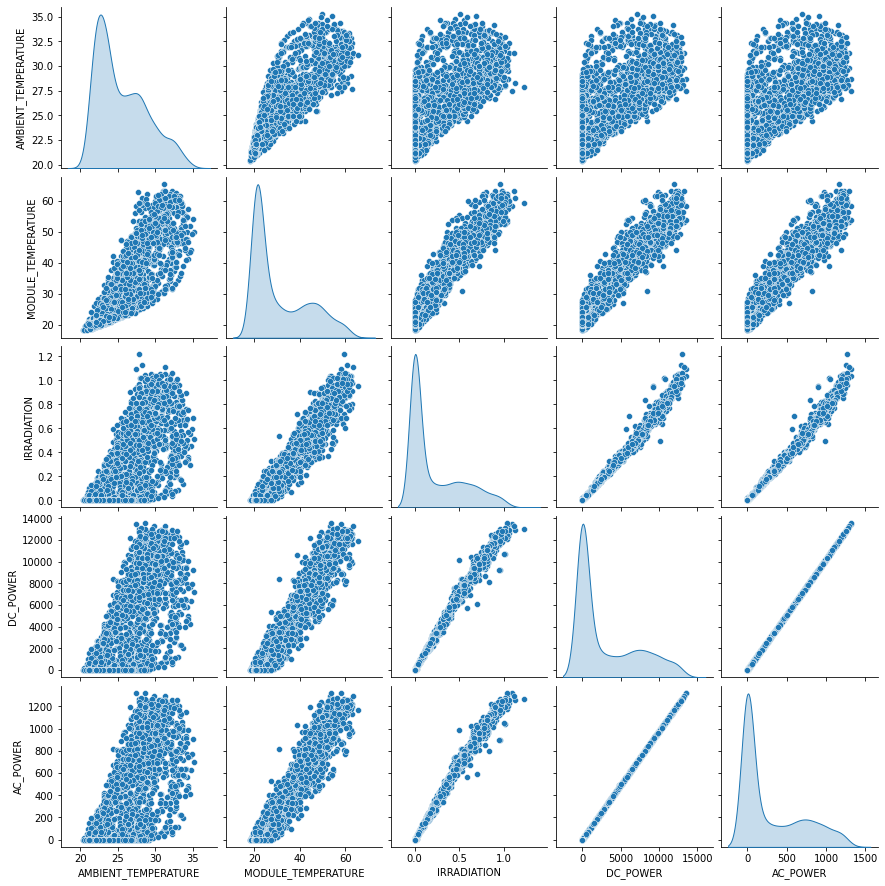

In [12]:
sns.pairplot(train_dataset[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER', 'AC_POWER']], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

count         mean          std        min        25%  \
HOUR                 2526.0    11.591053     6.857201   0.000000   6.000000   
MINUTE               2526.0    22.737530    16.713604   0.000000  15.000000   
AMBIENT_TEMPERATURE  2526.0    25.538547     3.349814  20.398505  22.711252   
MODULE_TEMPERATURE   2526.0    31.083193    12.275888  18.140415  21.150407   
IRRADIATION          2526.0     0.227710     0.300546   0.000000   0.000000   
DC_POWER             2526.0  3088.778173  3997.843776   0.000000   0.000000   
AC_POWER             2526.0   302.055006   390.624663   0.000000   0.000000   

                            50%          75%           max  
HOUR                  12.000000    18.000000     23.000000  
MINUTE                30.000000    45.000000     45.000000  
AMBIENT_TEMPERATURE   24.622521    27.888585     35.252486  
MODULE_TEMPERATURE    24.796631    41.191696     65.545714  
IRRADIATION            0.028563     0.447111      1.221652  
DC_POWER             391.516234  6352.798701  13542.199676  
AC_POWER              37.841234   622.138373   1320.407062

In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('AC_POWER')
test_labels = test_features.pop('AC_POWER')

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

mean          std
HOUR                   11.591053     6.857201
MINUTE                 22.737530    16.713604
AMBIENT_TEMPERATURE    25.538547     3.349814
MODULE_TEMPERATURE     31.083193    12.275888
IRRADIATION             0.227710     0.300546
DC_POWER             3088.778173  3997.843776
AC_POWER              302.055006   390.624663

In [16]:
normalizer = preprocessing.Normalization()

In [17]:
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[  11.591   22.738   25.539   31.083    0.228 3088.778]


In [18]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  12.      0.     27.87   38.48    0.22 3362.64]]

Normalized: [[ 0.06 -1.36  0.7   0.6  -0.02  0.07]]


In [19]:
irradiation = np.array(train_features['IRRADIATION'])

irradiation_normalizer = preprocessing.Normalization(input_shape=[1,])
irradiation_normalizer.adapt(irradiation)

In [20]:
irradiation_model = tf.keras.Sequential([
    irradiation_normalizer,
    layers.Dense(units=1)
])

irradiation_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
irradiation_model.predict(irradiation[:10])

array([[ 0.002],
       [ 0.085],
       [ 0.085],
       [ 0.085],
       [-0.115],
       [ 0.085],
       [ 0.085],
       [-0.029],
       [ 0.085],
       [ 0.085]], dtype=float32)

In [22]:
irradiation_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [23]:
%%time
history = irradiation_model.fit(
    train_features['IRRADIATION'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 22.3 s


In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss   val_loss  epoch
95  17.404869  14.295778     95
96  17.405317  14.285610     96
97  17.406715  14.290558     97
98  17.406450  14.310884     98
99  17.416307  14.287209     99

In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [IRRADIATION]')
  plt.legend()
  plt.grid(True)

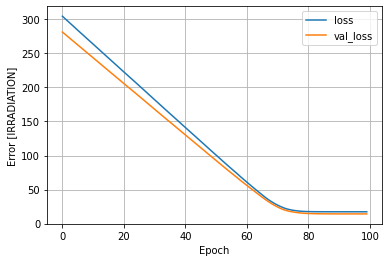

In [26]:
plot_loss(history)

In [27]:
test_results = {}

test_results['irradiation_model'] = irradiation_model.evaluate(
    test_features['IRRADIATION'],
    test_labels, verbose=0)

In [28]:
x = tf.linspace(0.0, 1.5, 200)
y = irradiation_model.predict(x)

In [29]:
def plot_irradiation(x, y):
  plt.scatter(train_features['IRRADIATION'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('IRRADIATION')
  plt.ylabel('AC power')
  plt.legend()

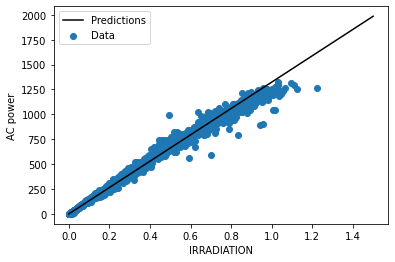

In [30]:
plot_irradiation(x,y)

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [32]:
linear_model.predict(train_features[:10])

array([[-0.313],
       [ 0.774],
       [ 0.445],
       [ 0.772],
       [ 0.191],
       [ 0.747],
       [ 1.046],
       [-0.754],
       [ 0.555],
       [-0.478]], dtype=float32)

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[ 0.238],
       [ 0.299],
       [ 0.344],
       [-0.34 ],
       [-0.789],
       [ 0.449]], dtype=float32)>

In [34]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 16.1 s


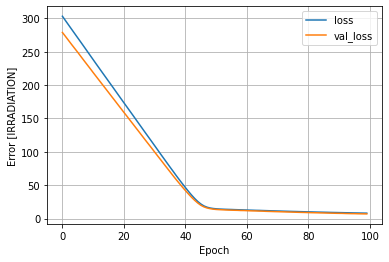

In [140]:
plot_loss(history)

In [36]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [37]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [38]:
dnn_irradiation_model = build_and_compile_model(irradiation_normalizer)
dnn_irradiation_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [39]:
%%time
history = dnn_irradiation_model.fit(
    train_features['IRRADIATION'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 16.8 s


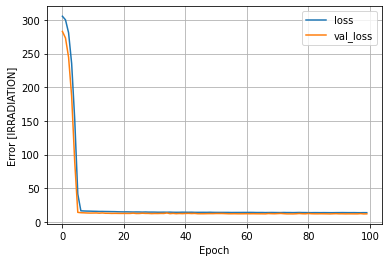

In [40]:
plot_loss(history)

In [41]:
y = dnn_irradiation_model.predict(x)

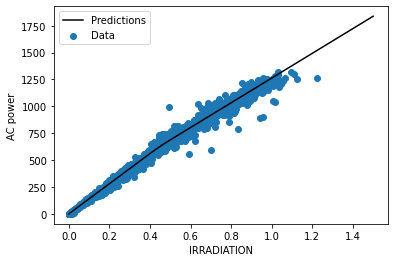

In [42]:
plot_irradiation(x, y)

In [43]:
test_results['dnn_irradiation_model'] = dnn_irradiation_model.evaluate(
    test_features['IRRADIATION'], test_labels,
    verbose=0)

In [44]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [45]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 17 s


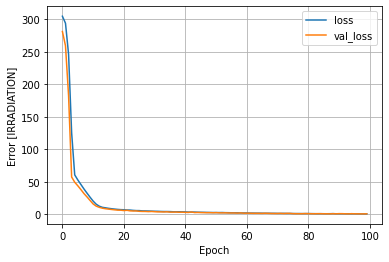

In [46]:
plot_loss(history)

In [47]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [48]:
pd.DataFrame(test_results, index=['Mean absolute error [AC_POWER]']).T

Mean absolute error [AC_POWER]
irradiation_model                           17.443712
linear_model                                 7.894411
dnn_irradiation_model                       13.717980
dnn_model                                    0.874300

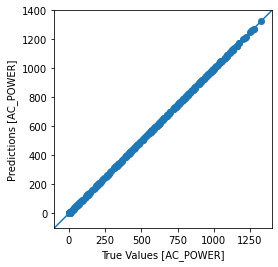

In [49]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [AC_POWER]')
plt.ylabel('Predictions [AC_POWER]')
lims = [-100, 1400]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


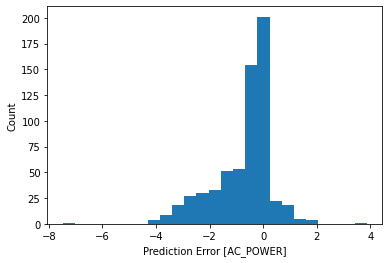

In [50]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [AC_POWER]')
_ = plt.ylabel('Count')

In [51]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [52]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [53]:
pd.DataFrame(test_results, index=['Mean absolute error [AC_POWER]']).T

Mean absolute error [AC_POWER]
irradiation_model                           17.443712
linear_model                                 7.894411
dnn_irradiation_model                       13.717980
dnn_model                                    0.874300
reloaded                                     0.874300